## Binary Task - Preprocess
- import and merge kaggle training/test set
- delete all comments not usefull for scoring (= -1)
- make toxicity label
- Text cleaning (emoji, non ASCII, email address, IP address,etc..)
- Terms tokenization & reduction (no stopword, stemming, lemmatization, bigrams,..)
- balance toxic and no-toxic labels
- export all-in-one dataset

In [1]:
import itertools
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [2]:
pd.options.display.max_colwidth = 300
pd.options.display.max_columns = 100

## Import Dataset

In [3]:
train = pd.read_csv("../data/train.csv")
train.shape

(159571, 8)

In [4]:
test = pd.read_csv("../data/test.csv")
test_lab = pd.read_csv("../data/test_labels.csv")
test = test.merge(test_lab, on="id")
test.shape

(153164, 8)

In [5]:
df = pd.concat([test, train])
df.shape

(312735, 8)

In [6]:
df.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when your view completely contradicts the coverage in reliable sources, why should anyone care what you feel? You can't even give a consistent argument - is the opening only supposed to mention significant aspects, or the """"most significant"""" ones? \n\n""",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is a horrible thing you put on my talk page. 128.61.19.93,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for prostitution ring. - Crunch Captain.",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand. I came here and my idea was bad right away. What kind of community goes """"you have bad ideas"""" go away, instead of helping rewrite them. """,0,0,0,0,0,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312735 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             312735 non-null  object
 1   comment_text   312735 non-null  object
 2   toxic          312735 non-null  int64 
 3   severe_toxic   312735 non-null  int64 
 4   obscene        312735 non-null  int64 
 5   threat         312735 non-null  int64 
 6   insult         312735 non-null  int64 
 7   identity_hate  312735 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 21.5+ MB


In [8]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,312735.000000,312735.000000,312735.000000,312735.000000,312735.000000,312735.000000
mean,-0.216803,-0.278907,-0.246362,-0.282978,-0.249035,-0.278411
std,0.553674,0.462240,0.513134,0.455311,0.509224,0.463074
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
df.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

## Feature Engeenering
- Comments not used for scoring are deleted. Their values are equal to -1.
- Make toxicity label.
    - =0 if the comment is not marked as toxic (no labelled)
    - =1 if exist at least a toxic label setted as 1

In [10]:
# Delete all comments not used for scoring (value equals to -1)
df = df[df['toxic']!= -1]

In [11]:
# Make the binary label
df['toxicity'] = (df.iloc[:, 2:].sum(axis=1) > 0).astype(int)

print("Legend:\nNo Toxic = 0\nToxic = 1\n")
print(f"Label frequency:\n{df['toxicity'].value_counts()}\n")
print(f"Label distributions:\n{df['toxicity'].value_counts(normalize=True)}")

Legend:
No Toxic = 0
Toxic = 1

Label frequency:
0    201081
1     22468
Name: toxicity, dtype: int64

Label distributions:
0    0.899494
1    0.100506
Name: toxicity, dtype: float64


In [12]:
df.shape

(223549, 9)

## Text Cleaning

In [13]:
import contractions
import nltk

In [14]:
def clean_text(text):
    text = text.encode("ascii", errors="ignore").decode() #Remove non ASCII
    text = text.lower()
    text = re.sub(r"(\n|\r|\t)+", " ", text) #remove \n, \r, \t
    text = contractions.fix(text) #Remove contractions (i'm --> i am)
    #text = spell(text) # Spelling is slow
    text = re.sub(r"\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}", "", text) #Remove IP Address
    text = re.sub(r"https?://\S+|www\.\S+", "", text) #Remove URLs
    text = re.sub(r"(?:^|(?<=[^\w@.)]))([\w+-](\.(?!\.))?)*?[\w+-]@(?:\w-?)*?\w+(\.([a-z]{2,})){1,3}(?:$|(?=\b))", "", text) #Remove Email
    text = re.sub(r"\[\[User.*", "", text) #Remove username
    text = re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', "", text) #Remove punctuation (si vuole fare?)
    #text = re.sub(r"(\w+.jpg$|\w+.png$)", "") #Remove filename (.jpg, .png, etc...)
    text = text.rstrip() #remove additional white space
    
    return text

In [15]:
import tqdm

clean_texts=[]
for text in tqdm.tqdm(df.comment_text):
    clean_texts.append(clean_text(text))

df['clean_text'] = clean_texts

100%|██████████| 223549/223549 [00:33<00:00, 6728.55it/s]


In [16]:
df['comment_text'][0], df['clean_text'][0]

("Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
 'explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now')

## Text Preprocessing

In [17]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

#PoS Tagging
nltk.download('averaged_perceptron_tagger')

stemmer = PorterStemmer()
lmtzr = WordNetLemmatizer()

stopwords = stopwords.words('english')
", ".join(stopwords)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/fgemignani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fgemignani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/fgemignani/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/fgemignani/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/fgemignani/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [18]:
#Tokenize
df['tokenized'] = df['clean_text'].apply(word_tokenize)

In [19]:
#Tokenize no stopwords
df['tokenized_no_stopwords'] = df['tokenized'].apply(lambda words: [word for word in words if word not in stopwords])

In [20]:
import sys
print(sys.getrecursionlimit())
sys.setrecursionlimit(5000)

3000


In [21]:
#Stemming
stem_list = []
for row in tqdm.tqdm(df['tokenized_no_stopwords']):
    stem_list.append([ stemmer.stem(word) for word in row ])

df['tokenized_stemmed'] = stem_list
#df['tokenized_stemmed'] = df['tokenized_no_stopwords'].apply(lambda words: [stemmer.stem(word) for word in words])

100%|██████████| 223549/223549 [02:46<00:00, 1346.42it/s]


In [22]:
#PoS
pos_list = []
for row in tqdm.tqdm(df['tokenized_no_stopwords']):
    pos_list.append(nltk.pos_tag(row))

df['tokenized_pos'] = pos_list
#df['tokenized_pos'] = df['tokenized_no_stopwords'].apply(lambda words: nltk.pos_tag(words))

100%|██████████| 223549/223549 [07:34<00:00, 491.46it/s]


In [23]:
#Lemma without PoS
df['tokenized_lemmatized'] = df['tokenized_no_stopwords'].apply(lambda words: [lmtzr.lemmatize(word) for word in words])

In [24]:
#Lemma with PoS
lemma_list = []

for words in tqdm.tqdm(df['tokenized_pos']):
    tmp=[]
    for lemma, pos in words:
        if pos.startswith("NN"):
            tmp.append(lmtzr.lemmatize(lemma, pos='n'))
        elif pos.startswith('VB'):
            tmp.append(lmtzr.lemmatize(lemma, pos='v'))
        elif pos.startswith('JJ'):
            tmp.append(lmtzr.lemmatize(lemma, pos='a'))
        elif pos.startswith('R'):
            tmp.append(lmtzr.lemmatize(lemma, pos='r'))
        else:
            tmp.append(lmtzr.lemmatize(lemma))
            
    lemma_list.append(tmp)
    
df['tokenized_lemmatized_pos'] = lemma_list

100%|██████████| 223549/223549 [00:35<00:00, 6386.63it/s]


In [25]:
#Bigrams
df['tokenized_bigram'] = df['tokenized_no_stopwords'].apply(lambda words: list(nltk.ngrams(words, 2)))

In [26]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxicity,clean_text,tokenized,tokenized_no_stopwords,tokenized_stemmed,tokenized_pos,tokenized_lemmatized,tokenized_lemmatized_pos,tokenized_bigram
5,0001ea8717f6de06,Thank you for understanding. I think very highly of you and would not revert without discussion.,0,0,0,0,0,0,0,thank you for understanding i think very highly of you and would not revert without discussion,"[thank, you, for, understanding, i, think, very, highly, of, you, and, would, not, revert, without, discussion]","[thank, understanding, think, highly, would, revert, without, discussion]","[thank, understand, think, highli, would, revert, without, discuss]","[(thank, NN), (understanding, VBG), (think, VBP), (highly, RB), (would, MD), (revert, VB), (without, IN), (discussion, NN)]","[thank, understanding, think, highly, would, revert, without, discussion]","[thank, understand, think, highly, would, revert, without, discussion]","[(thank, understanding), (understanding, think), (think, highly), (highly, would), (would, revert), (revert, without), (without, discussion)]"
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0,0,dear god this site is horrible,"[dear, god, this, site, is, horrible]","[dear, god, site, horrible]","[dear, god, site, horribl]","[(dear, JJ), (god, NN), (site, NN), (horrible, JJ)]","[dear, god, site, horrible]","[dear, god, site, horrible]","[(dear, god), (god, site), (site, horrible)]"
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Religion? Really?? You mean, the way people have invariably kept adding """"Religion"""" to the Samuel Beckett infobox? And why do you bother bringing up the long-dead completely non-existent """"Influences"""" issue? You're just flailing, making up crap on t...",0,0,0,0,0,0,0,somebody will invariably try to add religion really you mean the way people have invariably kept adding religion to the samuel beckett infobox and why do you bother bringing up the longdead completely nonexistent influences issue you are just flailing making up crap on the fly for compar...,"[somebody, will, invariably, try, to, add, religion, really, you, mean, the, way, people, have, invariably, kept, adding, religion, to, the, samuel, beckett, infobox, and, why, do, you, bother, bringing, up, the, longdead, completely, nonexistent, influences, issue, you, are, just, flailing, mak...","[somebody, invariably, try, add, religion, really, mean, way, people, invariably, kept, adding, religion, samuel, beckett, infobox, bother, bringing, longdead, completely, nonexistent, influences, issue, flailing, making, crap, fly, comparison, explicit, acknowledgement, entire, amos, oz, articl...","[somebodi, invari, tri, add, religion, realli, mean, way, peopl, invari, kept, ad, religion, samuel, beckett, infobox, bother, bring, longdead, complet, nonexist, influenc, issu, flail, make, crap, fli, comparison, explicit, acknowledg, entir, amo, oz, articl, person, jewish, categori]","[(somebody, NN), (invariably, RB), (try, VB), (add, RP), (religion, NN), (really, RB), (mean, JJ), (way, NN), (people, NNS), (invariably, RB), (kept, VBD), (adding, VBG), (religion, NN), (samuel, NN), (beckett, NN), (infobox, NN), (bother, IN), (bringing, VBG), (longdead, JJ), (completely, RB), ...","[somebody, invariably, try, add, religion, really, mean, way, people, invariably, kept, adding, religion, samuel, beckett, infobox, bother, bringing, longdead, completely, nonexistent, influence, issue, flailing, making, crap, fly, comparison, explicit, acknowledgement, entire, amos, oz, article...","[somebody, invariably, try, add, religion, really, mean, way, people, invariably, keep, add, religion, samuel, beckett, infobox, bother, bring, longdead, completely, nonexistent, influence, issue, flail, make, crap, fly, comparison, explicit, acknowledgement, entire, amos, oz, article, personall...","[(somebody, invariably), (invariably, try), (try, add), (add, religion), (religion, re

In [28]:
print(f"All data:\n{df['toxicity'].value_counts()}\n")

All data:
0    201081
1     22468
Name: toxicity, dtype: int64



In [29]:
df.shape

(223549, 17)

## Data Rebalancing
Random Undersampling is performed to rebalance toxic/no-toxic labels in order to obtain a reliable accuracy score.

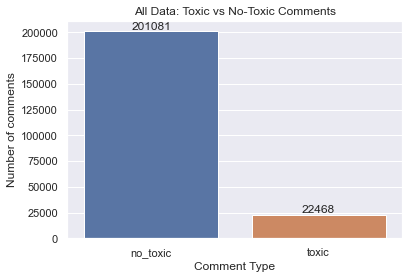

In [30]:
categories = ['no_toxic','toxic']
frequencies = [ df['toxicity'].value_counts()[0],df['toxicity'].value_counts()[1] ]
sns.set(font_scale = 1)

ax= sns.barplot(categories, frequencies)
plt.title("All Data: Toxic vs No-Toxic Comments")
plt.ylabel('Number of comments')
plt.xlabel('Comment Type')

#adding the text labels
rects = ax.patches
for rect, label in zip(rects, frequencies):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    
plt.show()

In [31]:
labels = df[['toxicity']]
data = df.drop('toxicity',axis=1,inplace=False)

In [32]:
under_sample = RandomUnderSampler(random_state=42)
data_under, labels_under = under_sample.fit_resample(data,labels)

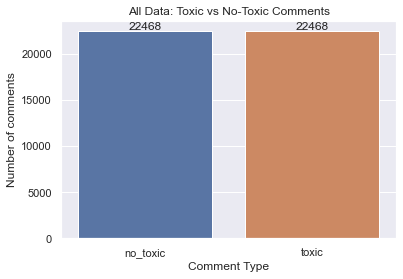

In [33]:
categories = ['no_toxic','toxic']
frequencies = [ labels_under['toxicity'].value_counts()[0],labels_under['toxicity'].value_counts()[1] ]
sns.set(font_scale = 1)

ax= sns.barplot(categories, frequencies)
plt.title("All Data: Toxic vs No-Toxic Comments")
plt.ylabel('Number of comments')
plt.xlabel('Comment Type')

#adding the text labels
rects = ax.patches
for rect, label in zip(rects, frequencies):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    
plt.show()

In [34]:
data_under['toxicity'] = labels_under
data_under.to_csv('./alldata-balanced-cleaned.zip',index=False)
data_under.shape

(44936, 17)